# Hierarchical Forecasting

In this notebook we take the example of demand forecasting on synthetic retail data and show you how to train and tune multiple hierarchichal time series models across algorithms and hyper-parameter combinations using the `scikit-hts` toolkit on Amazon SageMaker. We will first show you how to setup scikit-hts on SageMaker using the SKLearn estimator, then train multiple models using SageMaker Experiments, and finally use SageMaker Debugger to monitor suboptimal training and improve training efficiencies. We will walk you through the following steps:

1.	[Setup](#Setup)
2.	[Prepare Time Series Data](#Prepare-Time-Series-Data)
    - [Data Visualization](#Data-Visualization)
    - [Split data into train and test](#Split-data-into-train-and-test)
    - [Hierarchical Representation](#Hierarchical-Representation)
    - [Visualizing the tree structure](#Visualizing-the-tree-structure)
3.	[Setup the scikit-hts training script](#section3)
4.  [Setup Amazon SageMaker Experiment and Trials](#section4)
5.	[Setup the SKLearn Estimator](#section5)
6.	[Evaluate metrics and select a winning candidate](#section7)
7.	[Run time series forecasts](#Run-time-series-forecasts)
    - [Visualization at Region Level](#Visualization-at-Region-Level)
    - [Visualization at State Level](#Visualization-at-State-Level)


Before getting started we need to first install a few packages:

## Setup 

In [3]:
import warnings
warnings.simplefilter("ignore")

In [1]:
! pip install upgrade pip

distutils: /opt/conda/include/python3.6m/UNKNOWN
sysconfig: /opt/conda/include/python3.6m
user = False
home = None
root = None
prefix = None
ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


In [2]:
!pip install --user scikit-hts[prophet]

distutils: /root/.local/include/python3.6m/UNKNOWN
sysconfig: /root/.local/include/python3.6
user = True
home = None
root = None
prefix = None


In [3]:
! pip install --user plotly -q 
! pip install --user scikit-hts -q 
! pip install --user -U sagemaker -q

distutils: /root/.local/include/python3.6m/UNKNOWN
sysconfig: /root/.local/include/python3.6
user = True
home = None
root = None
prefix = None
distutils: /root/.local/include/python3.6m/UNKNOWN
sysconfig: /root/.local/include/python3.6
user = True
home = None
root = None
prefix = None
  distutils: /root/.local/include/python3.6m/sagemaker
  sysconfig: /root/.local/include/python3.6/sagemaker
  user = True
  home = None
  root = None
  prefix = None
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
distutils: /root/.local/include/python3.6m/UNKNOWN
sysconfig: /root/.local/include/python3.6
user = True
home = None
root = None
prefix = None


In [4]:
!conda install -c conda-forge fbprophet --yes
!conda install -c plotly plotly --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arviz-0.11.2               |     pyhd8ed1ab_1         1.4 MB  conda-forge
    binutils_impl_linux-64-2.36.1|       h193b22a_1         9.7 MB  conda-forge
    binutils_linux-64-2.36     |      hf3e587d_31          22 KB  conda-forge
    ca-certificates-2021.5.30  |       ha878542_0         136 KB  conda-forge
    certifi-2021.5.30          |   py36h5fab9bb_0         141 KB  conda-forge
    conda-4.10.3               |   py36h5fab9bb_0         3.1 MB  conda-forge
    convertdate-2.3.2          |     pyhd8ed1ab_0          37 KB  conda-forge

**Important** -- Make sure to restart the kernel.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from hts.hierarchy import HierarchyTree
from hts import HTSRegressor
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/opt/conda/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
import pandas as pd
import dataset_prep

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [5]:
import boto3
import sagemaker 

s3_client = boto3.client('s3')
s3res = boto3.resource('s3')

sess = sagemaker.Session()
bucket = sess.default_bucket()

pref = 'hierarchical-forecast-retail/scikit-hts'
s3_train_channel = "s3://" + bucket + "/" + pref + "/train.csv"
s3_test_channel = "s3://" + bucket + "/" + pref + "/test.csv"
print(s3_train_channel)
print(s3_test_channel)

s3://sagemaker-us-west-2-706553727873/hierarchical-forecast-retail/scikit-hts/train.csv
s3://sagemaker-us-west-2-706553727873/hierarchical-forecast-retail/scikit-hts/test.csv


## Prepare Time Series Data

In [6]:
## Read cleaned, joined, featurized data.
df_raw = pd.read_csv("retail-usa-clothing.csv"
                          , parse_dates=True
                          , header=0
                          , names=['date', 'state'
                                   , 'item', 'quantity', 'region'
                                   , 'country']
                    )
df_raw['quantity'] = df_raw['quantity'].astype(int)
# drop duplicates
print(df_raw.shape)
df_raw.drop_duplicates(inplace=True)

df_raw['date'] = pd.to_datetime(df_raw["date"])
print(df_raw.shape)
print(df_raw.dtypes)
print(f"Min timestamp = {df_raw.date.min()}")
print(f"Max timestamp = {df_raw.date.max()}")
df_raw.sample(5)

(388024, 6)
(388024, 6)
date        datetime64[ns]
state               object
item                object
quantity             int64
region              object
country             object
dtype: object
Min timestamp = 1997-11-25 00:00:00
Max timestamp = 2009-07-28 00:00:00


,date,state,item,quantity,region,country
71608,2007-03-02,Mississippi,kids_shoes,13,SouthCentral,USA
333884,2001-06-09,California,womens_shoes,22,Pacific,USA
370050,2007-01-23,Ohio,womens_shoes,35,EastNorthCentral,USA
290689,1999-12-02,Alabama,womens_shoes,15,SouthCentral,USA
61720,2003-06-11,Kentucky,mens_clothing,7,SouthCentral,USA


In [7]:
df_raw.region.unique()

array(['Mid-Alantic', 'SouthCentral', 'Pacific', 'EastNorthCentral',
       'NewEngland'], dtype=object)

In [8]:
df_raw.head()

,date,state,item,quantity,region,country
0,1997-11-25,NewYork,mens_clothing,8,Mid-Alantic,USA
1,1997-11-26,NewYork,mens_clothing,9,Mid-Alantic,USA
2,1997-11-27,NewYork,mens_clothing,11,Mid-Alantic,USA
3,1997-11-28,NewYork,mens_clothing,11,Mid-Alantic,USA
4,1997-11-29,NewYork,mens_clothing,10,Mid-Alantic,USA


In [9]:
## # map expected column names
item_id = "item"
target_value = "quantity"
timestamp = "date"
city = "city"
region = 'region'
country = 'country'

### Drop null item_ids

In [10]:
## Drop null item_ids
templist = df_raw[item_id].unique()
print(f"Number unique items: {len(templist)}")
print(f"Number nulls: {pd.isnull(templist).sum()}")

if len(templist) < 20:
    print(templist)

Number unique items: 6
Number nulls: 0
['mens_clothing' 'kids_clothing' 'womens_clothing' 'kids_shoes'
 'womens_shoes' 'mens_shoes']


In [11]:
## Drop the null item_ids, if any exist
if pd.isnull(templist).sum() > 0:
    print(df_raw.shape)
    df_raw = df_raw.loc[(~df_raw[item_id].isna()), :].copy()
    print(df_raw.shape)
    print(len(df_raw[item_id].unique()))
else:
    print("No missing item_ids found.")

No missing item_ids found.


### Drop null timestamps

In [12]:
# check null timestamps
templist = df_raw.loc[(df_raw[timestamp].isna()), :].shape[0]
print(f"Number nulls: {templist}")

if (templist < 10) & (templist > 0) :
    print(df_raw.loc[(df_raw[timestamp].isna()), :])

Number nulls: 0


In [13]:
## Drop the null quantities and dates
if templist > 0:
    print(df_raw.shape)
    df_raw = df_raw.loc[(~df_raw[timestamp].isna()), :].copy()
    print(df_raw.shape)
    print(df_raw['date'].isna().sum())
else:
    print("No null dates found.")

No null dates found.


In [14]:
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
groups = df_raw.groupby(Grouper(key=item_id))

## Data Visualization

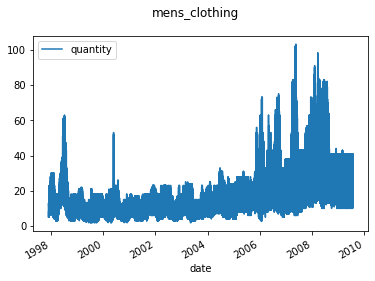

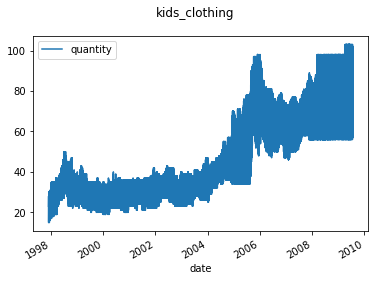

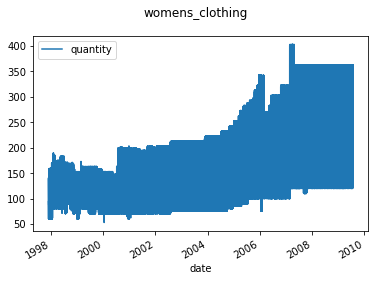

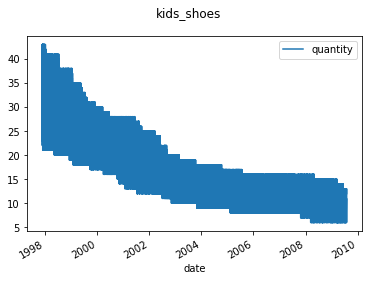

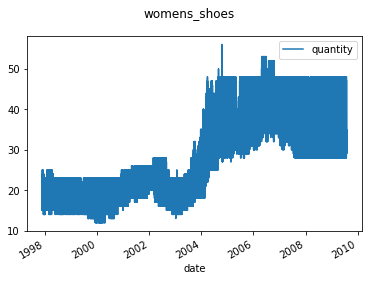

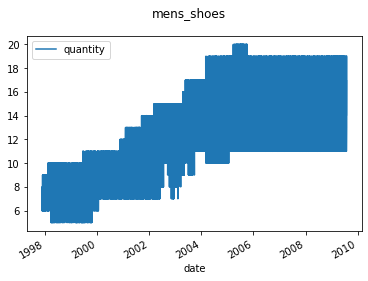

In [15]:
## Plots
for name, group in groups:
    group.plot(subplots=True,title=name, x=timestamp, y=target_value, legend=True)
    pyplot.show()

### Split data into train and test

In [16]:
df_train = df_raw.query(f'date <= "2009-04-29"').copy()
df_train.to_csv("train.csv")
s3_client.upload_file("train.csv", bucket, pref+"/train.csv")

In [17]:
df_test = df_raw.query(f'date > "2009-04-29"').copy()
df_test.to_csv("test.csv")
s3_client.upload_file("test.csv", bucket, pref+"/test.csv")

In [18]:
df_train.head()

,date,state,item,quantity,region,country
0,1997-11-25,NewYork,mens_clothing,8,Mid-Alantic,USA
1,1997-11-26,NewYork,mens_clothing,9,Mid-Alantic,USA
2,1997-11-27,NewYork,mens_clothing,11,Mid-Alantic,USA
3,1997-11-28,NewYork,mens_clothing,11,Mid-Alantic,USA
4,1997-11-29,NewYork,mens_clothing,10,Mid-Alantic,USA


In [42]:
product = df_train[(df_train['item'] == "mens_clothing")]
product.head()

,date,state,item,quantity,region,country
0,1997-11-25,NewYork,mens_clothing,8,Mid-Alantic,USA
1,1997-11-26,NewYork,mens_clothing,9,Mid-Alantic,USA
2,1997-11-27,NewYork,mens_clothing,11,Mid-Alantic,USA
3,1997-11-28,NewYork,mens_clothing,11,Mid-Alantic,USA
4,1997-11-29,NewYork,mens_clothing,10,Mid-Alantic,USA


In [44]:
def get_region_columns(df, region):
    return [col for col in df.columns if region in col]


In [45]:
product["region_state"] = product.apply(lambda x: f"{x['region']}_{x['state']}", axis=1)
region_states = product["region_state"].unique()
grouped_sections = product.groupby(["region", "region_state"])
edges_hierarchy = list(grouped_sections.groups.keys())
# Now, we must not forget that total is our root node.
second_level_nodes = product.region.unique()
root_node = "total"
root_edges = [(root_node, second_level_node) for second_level_node in second_level_nodes]
root_edges += edges_hierarchy
product_bottom_level = product.pivot(index="date", columns="region_state", values="quantity")
regions = product["region"].unique().tolist()
for region in regions:
    region_cols = get_region_columns(product_bottom_level, region)
    product_bottom_level[region] = product_bottom_level[region_cols].sum(axis=1)

product_bottom_level["total"] = product_bottom_level[regions].sum(axis=1)

# create hierarchy
# Now that we have our dataset ready, let's define our hierarchy tree. 
# We need a dictionary, where each key is a column (node) in our hierarchy and a list of its children.
hierarchy = dict()

for edge in root_edges:
    parent, children = edge[0], edge[1]
    hierarchy.get(parent)
    if not hierarchy.get(parent):
        hierarchy[parent] = [children]
    else:
        hierarchy[parent] += [children]

product_bottom_level.index = pd.to_datetime(product_bottom_level.index)
product_bottom_level = product_bottom_level.resample("D").sum()

## Hierarchical Representation

*scikit-hts* requires that each column in our DataFrame is a time series of its own, for all hierarchy levels. Let's do that. Remember that our data is in a long format.

The steps are the following:

1. Transform dataset into a column oriented one
2. Create the hierarchy representation as a dictionary
 
For a complete description of how that is done under the hood, and for a sense of what the API accepts, see [scikit-hts' docs](https://scikit-hts.readthedocs.io/en/latest/hierarchy.html)

In [19]:
#Let's take a look at the training script
!pygmentize code/dataset_prep.py

import os
# os.system('pip install pandas')
# os.system('pip install scikit-hts')
# os.system('pip install plotly -q')
# os.system('pip install scikit-hts[prophet]')
# os.system('pip install scikit-hts[auto-arima]')

# os.system('conda install -c conda-forge fbprophet --yes')
import pandas as pd
import pathlib
import numpy as np
import argparse
import json
import boto3
from hts import HTSRegressor
import joblib
import ast
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

s3 = boto3.client("s3")
# Aggregate data by region and Quantity
def get_region_columns(df, region):
    return [col for col in df.columns if region in col]

def prepare_data(df_raw):
    print('******************* Prepare Data **********************')
    product = df_raw[(df_raw['item'] == "mens_clothing")]
    product["region_state"] = product.apply(lambda x: f"{x['region']}_{x['state']}", axis=1)
    re

In [20]:
train_hierarchy, train_product_bottom_level, region_states = dataset_prep.prepare_data(df_train)

******************* Prepare Data **********************
        date    state           item  quantity       region country
0 1997-11-25  NewYork  mens_clothing         8  Mid-Alantic     USA
1 1997-11-26  NewYork  mens_clothing         9  Mid-Alantic     USA
2 1997-11-27  NewYork  mens_clothing        11  Mid-Alantic     USA
3 1997-11-28  NewYork  mens_clothing        11  Mid-Alantic     USA
4 1997-11-29  NewYork  mens_clothing        10  Mid-Alantic     USA
******************* End Prepare Data **********************


In [21]:
test_hierarchy, test_product_bottom_level, region_states = dataset_prep.prepare_data(df_test)

******************* Prepare Data **********************
           date    state           item  quantity       region country
4174 2009-04-30  NewYork  mens_clothing        31  Mid-Alantic     USA
4175 2009-05-01  NewYork  mens_clothing        32  Mid-Alantic     USA
4176 2009-05-02  NewYork  mens_clothing        32  Mid-Alantic     USA
4177 2009-05-03  NewYork  mens_clothing        32  Mid-Alantic     USA
4178 2009-05-04  NewYork  mens_clothing        33  Mid-Alantic     USA
******************* End Prepare Data **********************


## Visualizing the tree structure

In [22]:
from hts.hierarchy import HierarchyTree

ht = HierarchyTree.from_nodes(nodes=train_hierarchy, df=train_product_bottom_level)

In [23]:
print(ht)

- total
   |- Mid-Alantic
   |  |- Mid-Alantic_NewJersey
   |  |- Mid-Alantic_NewYork
   |  - Mid-Alantic_Pennsylvania
   |- SouthCentral
   |  |- SouthCentral_Alabama
   |  |- SouthCentral_Kentucky
   |  |- SouthCentral_Mississippi
   |  - SouthCentral_Tennessee
   |- Pacific
   |  |- Pacific_Alaska
   |  |- Pacific_California
   |  |- Pacific_Hawaii
   |  - Pacific_Oregon
   |- EastNorthCentral
   |  |- EastNorthCentral_Illinois
   |  |- EastNorthCentral_Indiana
   |  - EastNorthCentral_Ohio
   - NewEngland
      |- NewEngland_Connecticut
      |- NewEngland_Maine
      |- NewEngland_RhodeIsland
      - NewEngland_Vermont



In [24]:
print(ht.children[1].key)
print(ht.children[1])

SouthCentral
- SouthCentral
   |- SouthCentral_Alabama
   |- SouthCentral_Kentucky
   |- SouthCentral_Mississippi
   - SouthCentral_Tennessee



In [25]:
print(ht.get_node('NewEngland'))

- NewEngland
   |- NewEngland_Connecticut
   |- NewEngland_Maine
   |- NewEngland_RhodeIsland
   - NewEngland_Vermont



In [26]:
regions = df_raw["region"].unique().tolist()
regions

['Mid-Alantic', 'SouthCentral', 'Pacific', 'EastNorthCentral', 'NewEngland']

## Create the algorithm and hyper-parameters combinatorial matrix <a name=section2></a>

In [31]:
import pandas as pd
d = {'revision_method': ["BU", "AHP"], 'seasonality_mode':["additive", "multiplicative"]}
df_hps = pd.DataFrame(data=d)
df_hps.head()

,revision_method,seasonality_mode
0,BU,additive
1,AHP,multiplicative


We will use the 'product' function to derive combinations of these parameters from the base set into separate rows in the dataframe. Each row corresponds to a training job configuration that we will subsequently pass to the SKLearn Estimator to run the training job.

Note Please check your AWS account limits before you setup the product function below. The training process in the sections below will run one training job per row from this dataframe. Based on your account limit for the maximum number of concurrent training jobs, you may get an error that the limit has been exceeded.

In [32]:
from itertools import product

prod = product(df_hps['seasonality_mode'].unique(), df_hps['revision_method'].unique())

df_hps_combo = pd.DataFrame([list(p) for p in prod],
                   columns=list(['seasonality_mode', 'revision_method']))

df_hps_combo['jobnumber'] = df_hps_combo.index

Let's take a look on the different combinations. 

In [33]:
df_hps_combo

,seasonality_mode,revision_method,jobnumber
0,additive,BU,0
1,additive,AHP,1
2,multiplicative,BU,2
3,multiplicative,AHP,3


## Setup the scikit-hts training script

In [34]:
#Let's take a look at the training script
!pygmentize code/train.py

import os
# os.system('pip install pandas')
# os.system('pip install scikit-hts')
# os.system('pip install plotly -q')
# os.system('pip install scikit-hts[prophet]')
# os.system('pip install scikit-hts[auto-arima]')

# os.system('conda install -c conda-forge fbprophet --yes')
import pandas as pd
import pathlib
import numpy as np
import argparse
import json
import boto3
from hts import HTSRegressor
import joblib
import ast
import plotly.graph_objects as go
from dataset_prep import prepare_data
import sklearn
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

s3 = boto3.client("s3")

def train(bucket, seasonality_mode, algo, daily_seasonality, changepoint_prior_scale, revision_method):
    print('**************** Training Script ***********************')
    # create train dataset
    df = pd.read_csv(filepath_or_buffer=os.environ['SM_CHANNEL_TRAIN'] + "/train.c

## Setup a SageMaker Experiment  <a name=section4></a>

Before create the training job, we first create a SageMaker Experiment that will allow us to track the different training jobs. We use the `smexperiments` libraray to create the experiment:

In [35]:
from datetime import datetime
from smexperiments.experiment import Experiment

sagemaker_boto_client = boto3.client("sagemaker")

#name of experiment
timestep = datetime.now()
timestep = timestep.strftime("%d-%m-%Y-%H-%M-%S")
experiment_name = "hierarchical-forecast-models-" + timestep

#create experiment
Experiment.create(
    experiment_name=experiment_name, 
    description="Hierarchical Timeseries models", 
    sagemaker_boto_client=sagemaker_boto_client)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f18aa658208>,experiment_name='hierarchical-forecast-models-15-05-2021-07-23-49',description='Timeseries models',tags=None,experiment_arn='arn:aws:sagemaker:us-west-2:706553727873:experiment/hierarchical-forecast-models-15-05-2021-07-23-49',response_metadata={'RequestId': '32454cee-e79f-412d-b45b-a4ce3b18182e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '32454cee-e79f-412d-b45b-a4ce3b18182e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '120', 'date': 'Sat, 15 May 2021 07:23:49 GMT'}, 'RetryAttempts': 0})

For each job we define a new Trial component within that experiment:

In [36]:
from smexperiments.trial import Trial

trial = Trial.create(
    experiment_name=experiment_name,
    sagemaker_boto_client=sagemaker_boto_client
)
print(trial)

Trial(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f18aa658208>,trial_name='Trial-2021-05-15-072349-goim',experiment_name='hierarchical-forecast-models-15-05-2021-07-23-49',tags=None,trial_arn='arn:aws:sagemaker:us-west-2:706553727873:experiment-trial/trial-2021-05-15-072349-goim',response_metadata={'RequestId': 'ef31db9a-4147-4d78-98b0-47c323037052', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'ef31db9a-4147-4d78-98b0-47c323037052', 'content-type': 'application/x-amz-json-1.1', 'content-length': '101', 'date': 'Sat, 15 May 2021 07:23:49 GMT'}, 'RetryAttempts': 0})


In [37]:
experiment_config = { "ExperimentName": experiment_name, 
                      "TrialName":  trial.trial_name,
                      "TrialComponentDisplayName": "Training"}

## Fitting models

We will use scikit-hts to fit `Prophet` model in our data and compare results.
- Prophet: 
    - *daily_seasonality* : By default daily seasonality is set to `False`, therefore, explicitly changing it to `True`
    - *changepoint_prior_scale* : If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to `0.05`. Increasing it will make the trend more flexible.


In [38]:
metric_definitions=[
    {'Name': 'Total:MSE', 'Regex': 'Total: MSE: ([0-9\\.]+)'},
    {'Name': 'Mid-Alantic:MSE', 'Regex': 'Mid-Alantic: MSE: ([0-9\\.]+)'},
    {'Name': 'SouthCentral:MSE', 'Regex': 'SouthCentral: MSE: ([0-9\\.]+)'},
    {'Name': 'Pacific:MSE', 'Regex': 'Pacific: MSE: ([0-9\\.]+)'},
    {'Name': 'EastNorthCentral:MSE', 'Regex': 'EastNorthCentral: MSE: ([0-9\\.]+)'},
    {'Name': 'NewEngland:MSE', 'Regex': 'NewEngland: MSE: ([0-9\\.]+)'},
    {'Name': 'NewYork:MSE', 'Regex': 'NewYork:MSE: ([0-9\\.]+)'},
    {'Name': 'Alabama:MSE', 'Regex': 'Alabama:MSE: ([0-9\\.]+)'},
    {'Name': 'Alaska:MSE', 'Regex': 'Alaska:MSE: ([0-9\\.]+)'},
    {'Name': 'Kentucky:MSE', 'Regex': 'Kentucky:MSE: ([0-9\\.]+)'},
    {'Name': 'Illinois:MSE', 'Regex': 'Illinois:MSE: ([0-9\\.]+)'},
    {'Name': 'Mississippi:MSE', 'Regex': 'Mississippi:MSE: ([0-9\\.]+)'},
    {'Name': 'Hawaii:MSE', 'Regex': 'Hawaii:MSE: ([0-9\\.]+)'},
    {'Name': 'Indiana:MSE', 'Regex': 'Indiana:MSE: ([0-9\\.]+)'},
    {'Name': 'NewJersey:MSE', 'Regex': 'NewJersey:MSE: ([0-9\\.]+)'},
    {'Name': 'Pennsylvania:MSE', 'Regex': 'Pennsylvania:MSE: ([0-9\\.]+)'},
    {'Name': 'Tennessee:MSE', 'Regex': 'Tennessee:MSE: ([0-9\\.]+)'},
    {'Name': 'California:MSE', 'Regex': 'California:MSE: ([0-9\\.]+)'},
    {'Name': 'RhodeIsland:MSE', 'Regex': 'RhodeIsland:MSE: ([0-9\\.]+)'},
    {'Name': 'Oregon:MSE', 'Regex': 'Oregon:MSE: ([0-9\\.]+)'},
    {'Name': 'Connecticut:MSE', 'Regex': 'Connecticut:MSE: ([0-9\\.]+)'},
    {'Name': 'Maine:MSE', 'Regex': 'Maine:MSE: ([0-9\\.]+)'},
    {'Name': 'Ohio:MSE', 'Regex': 'Ohio:MSE: ([0-9\\.]+)'},
    {'Name': 'Vermont:MSE', 'Regex': 'Vermont:MSE: ([0-9\\.]+)'},
]

### Create the SKLearn Estimator  <a name=section5></a>


In [39]:
import sagemaker
from sagemaker.sklearn import SKLearn

for idx, row in df_hps_combo.iterrows():
    trial = Trial.create(
        experiment_name=experiment_name,
        sagemaker_boto_client=sagemaker_boto_client
    )

    experiment_config = { "ExperimentName": experiment_name, 
                      "TrialName":  trial.trial_name,
                      "TrialComponentDisplayName": "Training"}
    

    sklearn_estimator = SKLearn('train.py',
                                source_dir='code',
                                instance_type='ml.m4.xlarge',
                                framework_version='0.23-1',
                                role=sagemaker.get_execution_role(),
                                debugger_hook_config=False,
                                hyperparameters = {'bucket': bucket,
                                                   'algo': "Prophet", 
                                                   'daily_seasonality': True,
                                                   'changepoint_prior_scale': 0.5,
                                                   'seasonality_mode': row['seasonality_mode'],
                                                   'revision_method' : row['revision_method']
                                                  },
                                metric_definitions = metric_definitions,
                               )
    sklearn_estimator.fit({'train': s3_train_channel, "test": s3_test_channel},
                     experiment_config=experiment_config, wait=True)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2021-05-15-07-23-49-897


2021-05-15 07:23:50 Starting - Starting the training job...
2021-05-15 07:24:13 Starting - Launching requested ML instancesProfilerReport-1621063430: InProgress
......
2021-05-15 07:25:18 Starting - Preparing the instances for training.........
2021-05-15 07:26:45 Downloading - Downloading input data
2021-05-15 07:26:45 Training - Downloading the training image....2021-05-15 07:27:23,587 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-05-15 07:27:23,589 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-15 07:27:23,601 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-05-15 07:27:23,901 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
  ERROR: Command errored out with exit status 1:
   command: /miniconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/home/

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.


Training seconds: 456
Billable seconds: 456


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2021-05-15-07-34-37-157


2021-05-15 07:34:37 Starting - Starting the training job...
2021-05-15 07:35:00 Starting - Launching requested ML instancesProfilerReport-1621064077: InProgress
......
2021-05-15 07:36:06 Starting - Preparing the instances for training.........
2021-05-15 07:37:36 Downloading - Downloading input data
2021-05-15 07:37:36 Training - Downloading the training image.....2021-05-15 07:38:16,863 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-05-15 07:38:16,866 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-15 07:38:16,877 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-05-15 07:38:17,173 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt

2021-05-15 07:38:21 Training - Training image download completed. Training in progress.  Building wheel for fbprophet (setup.py): finished with stat

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.


Training seconds: 438
Billable seconds: 438


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2021-05-15-07-44-54-719


2021-05-15 07:44:55 Starting - Starting the training job...
2021-05-15 07:45:18 Starting - Launching requested ML instancesProfilerReport-1621064694: InProgress
......
2021-05-15 07:46:18 Starting - Preparing the instances for training.........
2021-05-15 07:47:46 Downloading - Downloading input data
2021-05-15 07:47:46 Training - Downloading the training image...
2021-05-15 07:48:24 Training - Training image download completed. Training in progress..2021-05-15 07:48:24,145 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-05-15 07:48:24,147 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-15 07:48:24,163 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-05-15 07:48:24,486 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
  ERROR: Command errored out with exit status 1:
   command: /

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.


Training seconds: 418
Billable seconds: 418


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2021-05-15-07-54-41-738


2021-05-15 07:54:42 Starting - Starting the training job...
2021-05-15 07:54:43 Starting - Launching requested ML instancesProfilerReport-1621065281: InProgress
......
2021-05-15 07:55:56 Starting - Preparing the instances for training.........
2021-05-15 07:57:37 Downloading - Downloading input data
2021-05-15 07:57:37 Training - Downloading the training image...
2021-05-15 07:58:04 Training - Training image download completed. Training in progress..2021-05-15 07:58:06,157 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-05-15 07:58:06,160 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-05-15 07:58:06,174 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-05-15 07:58:06,552 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
  ERROR: Command errored out with exit status 1:
   command: /

Once the experiment is finished we can determine how many seconds it ran. First we define a helper function to compute the billabale seconds and how many training jobs were auto-terminated.

## Evaluate metrics and select a winning candidate <a name=section8></a>
Amazon SageMaker Studio provides an experiments browser that you can use to view lists of experiments, trials, and trial components. You can choose one of these entities to view detailed information about the entity or choose multiple entities for comparison. For more details please refer to [the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments-view-compare.html#experiments-view). Once the training jobs are running we can use the experiment view in Studio (see screenshot below) or the `ExperimentAnalytics` module to track the status of our training jobs and their metrics. 
![](screenshot.png)


In the training script we used SageMaker Debugger's function `save_scalar` to store metrics such as MAPE, MSE, RMSE in the experiment. We can access the recorded metrics via the ExperimentAnalytics function and convert it to a Pandas dataframe.


In [40]:
def compute_job_statistics(df):
    total_cost  = 0
    stopped = 0
    for name in df['sagemaker_job_name']:
        description = sagemaker_boto_client.describe_training_job(TrainingJobName=name[1:-1])
        total_cost += description['BillableTimeInSeconds']
        if description['TrainingJobStatus'] == "Stopped":
            stopped += 1
    return stopped, total_cost

In [41]:
from sagemaker.analytics import ExperimentAnalytics
trial_component_analytics = ExperimentAnalytics(experiment_name=experiment_name)

stopped, total_cost = compute_job_statistics(trial_component_analytics.dataframe())
print("Billable seconds for overall experiment:", total_cost, "seconds. Number of training jobs auto-terminated:", stopped)

Billable seconds for overall experiment: 1713 seconds. Number of training jobs auto-terminated: 0


This setup is especially useful if you run a parameter sweep with training jobs that train for hours. In our case each job only trained for less than 10 minutes. Until the Debugger data is uploaded, fetched and downloaded into the processing job, a few minutes may pass, so the potential cost reduction will be less for smaller training jobs.

In [42]:
from sagemaker.analytics import ExperimentAnalytics

trial_component_analytics = ExperimentAnalytics(experiment_name=experiment_name)
tc_df = trial_component_analytics.dataframe()
tc_df

,TrialComponentName,DisplayName,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,algo,bucket,changepoint_prior_scale,...,SouthCentral:MSE - Last,SouthCentral:MSE - Count,test - MediaType,test - Value,train - MediaType,train - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,Trials,Experiments
0,sagemaker-scikit-learn-2021-05-15-07-54-41-738...,Training,arn:aws:sagemaker:us-west-2:706553727873:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m4.xlarge,30.0,"""Prophet""","""sagemaker-us-west-2-706553727873""",0.5,...,4862.082811,1,None,s3://sagemaker-us-west-2-706553727873/hierarch...,None,s3://sagemaker-us-west-2-706553727873/hierarch...,None,s3://sagemaker-us-west-2-706553727873/sagemake...,[Trial-2021-05-15-075441-upot],[hierarchical-forecast-models-15-05-2021-07-23...
1,sagemaker-scikit-learn-2021-05-15-07-44-54-719...,Training,arn:aws:sagemaker:us-west-2:706553727873:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m4.xlarge,30.0,"""Prophet""","""sagemaker-us-west-2-706553727873""",0.5,...,164.336023,1,None,s3://sagemaker-us-west-2-706553727873/hierarch...,None,s3://sagemaker-us-west-2-706553727873/hierarch...,None,s3://sagemaker-us-west-2-706553727873/sagemake...,[Trial-2021-05-15-074454-qxbz],[hierarchical-forecast-models-15-05-2021-07-23...
2,sagemaker-scikit-learn-2021-05-15-07-34-37-157...,Training,arn:aws:sagemaker:us-west-2:706553727873:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m4.xlarge,30.0,"""Prophet""","""sagemaker-us-west-2-706553727873""",0.5,...,6923.598895,1,None,s3://sagemaker-us-west-2-706553727873/hierarch...,None,s3://sagemaker-us-west-2-706553727873/hierarch...,None,s3://sagemaker-us-west-2-706553727873/sagemake...,[Trial-2021-05-15-073437-kusw],[hierarchical-forecast-models-15-05-2021-07-23...
3,sagemaker-scikit-learn-2021-05-15-07-23-49-897...,Training,arn:aws:sagemaker:us-west-2:706553727873:train...,246618743249.dkr.ecr.us-west-2.amazonaws.com/s...,1.0,ml.m4.xlarge,30.0,"""Prophet""","""sagemaker-us-west-2-706553727873""",0.5,...,49.344547,1,None,s3://sagemaker-us-west-2-706553727873/hierarch...,None,s3://sagemaker-us-west-2-706553727873/hierarch...,None,s3://sagemaker-us-west-2-706553727873/sagemake...,[Trial-2021-05-15-072349-fyaz],[hierarchical-forecast-models-15-05-2021-07-23...


In [43]:
total_mse = []
model_url = []
for name in tc_df['sagemaker_job_name']:
        description = sagemaker_boto_client.describe_training_job(TrainingJobName=name[1:-1])
        total_mse.append(description['FinalMetricDataList'][0]['Value'])
        model_url.append(description['ModelArtifacts']['S3ModelArtifacts'])
tc_df['total_mse'] = total_mse

In [44]:
description['FinalMetricDataList'][0]['Value']

665159.5

Let's take a look on the metrics and hyperparameter combinations:

In [45]:
new_df = tc_df[['sagemaker_job_name','algo', 'changepoint_prior_scale', 'revision_method', 'total_mse', 'seasonality_mode']]
new_df  

,sagemaker_job_name,algo,changepoint_prior_scale,revision_method,total_mse,seasonality_mode
0,"""sagemaker-scikit-learn-2021-05-15-07-54-41-738""","""Prophet""",0.5,"""AHP""",56837.589844,"""multiplicative"""
1,"""sagemaker-scikit-learn-2021-05-15-07-44-54-719""","""Prophet""",0.5,"""BU""",108293.312500,"""multiplicative"""
2,"""sagemaker-scikit-learn-2021-05-15-07-34-37-157""","""Prophet""",0.5,"""AHP""",104734.328125,"""additive"""
3,"""sagemaker-scikit-learn-2021-05-15-07-23-49-897""","""Prophet""",0.5,"""BU""",665159.500000,"""additive"""


In [46]:
mse_min = new_df['total_mse'].min()
mse_min

56837.58984375

Let's select the winner model:

In [47]:
df_winner = new_df[new_df['total_mse'] == mse_min]

Download the winning model for running forecasts.

In [48]:
for name in df_winner['sagemaker_job_name']:
    model_dir = sagemaker_boto_client.describe_training_job(TrainingJobName = name[1:-1])['ModelArtifacts']['S3ModelArtifacts']
model_dir

's3://sagemaker-us-west-2-706553727873/sagemaker-scikit-learn-2021-05-15-07-54-41-738/output/model.tar.gz'

In [49]:
model_dir

's3://sagemaker-us-west-2-706553727873/sagemaker-scikit-learn-2021-05-15-07-54-41-738/output/model.tar.gz'

In [50]:
key = model_dir.split('s3://{}/'.format(bucket))

In [51]:
s3_client.download_file(bucket, key[1], 'model.tar.gz')

In [52]:
!tar -xvzf model.tar.gz

model.joblib


## Run time series forecasts
First, let's load the model. 

In [53]:
import joblib
def model_fn(model_dir):
    clf = joblib.load(model_dir)
    return clf

In [54]:
model = model_fn('model.joblib')

In [55]:
model

HTSRegressor(n_jobs=4,
             revision_method=<hts.revision.RevisionMethod object at 0x7f18a9fabda0>)

Now, let's make forecasts 90 days in future.

In [56]:
predictions = model.predict(steps_ahead=90)

Fitting models: 100%|██████████| 12/12 [02:07<00:00, 10.60s/it]
INFO:hts.core.regressor:Reconciling forecasts using <hts.revision.RevisionMethod object at 0x7f18a9fabda0>


Let's visualize the model results and fitted values for all states.

In [57]:
## Helper function for plotting results.
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
def plot_results(cols, axes, preds):
    axes = np.hstack(axes)
    for ax, col in zip(axes, cols):
        preds[col].plot(ax=ax, label="Predicted")
        train_product_bottom_level[col].plot(ax=ax, label="Observed")
        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("Quantity")    

#### Visualization at Region Level

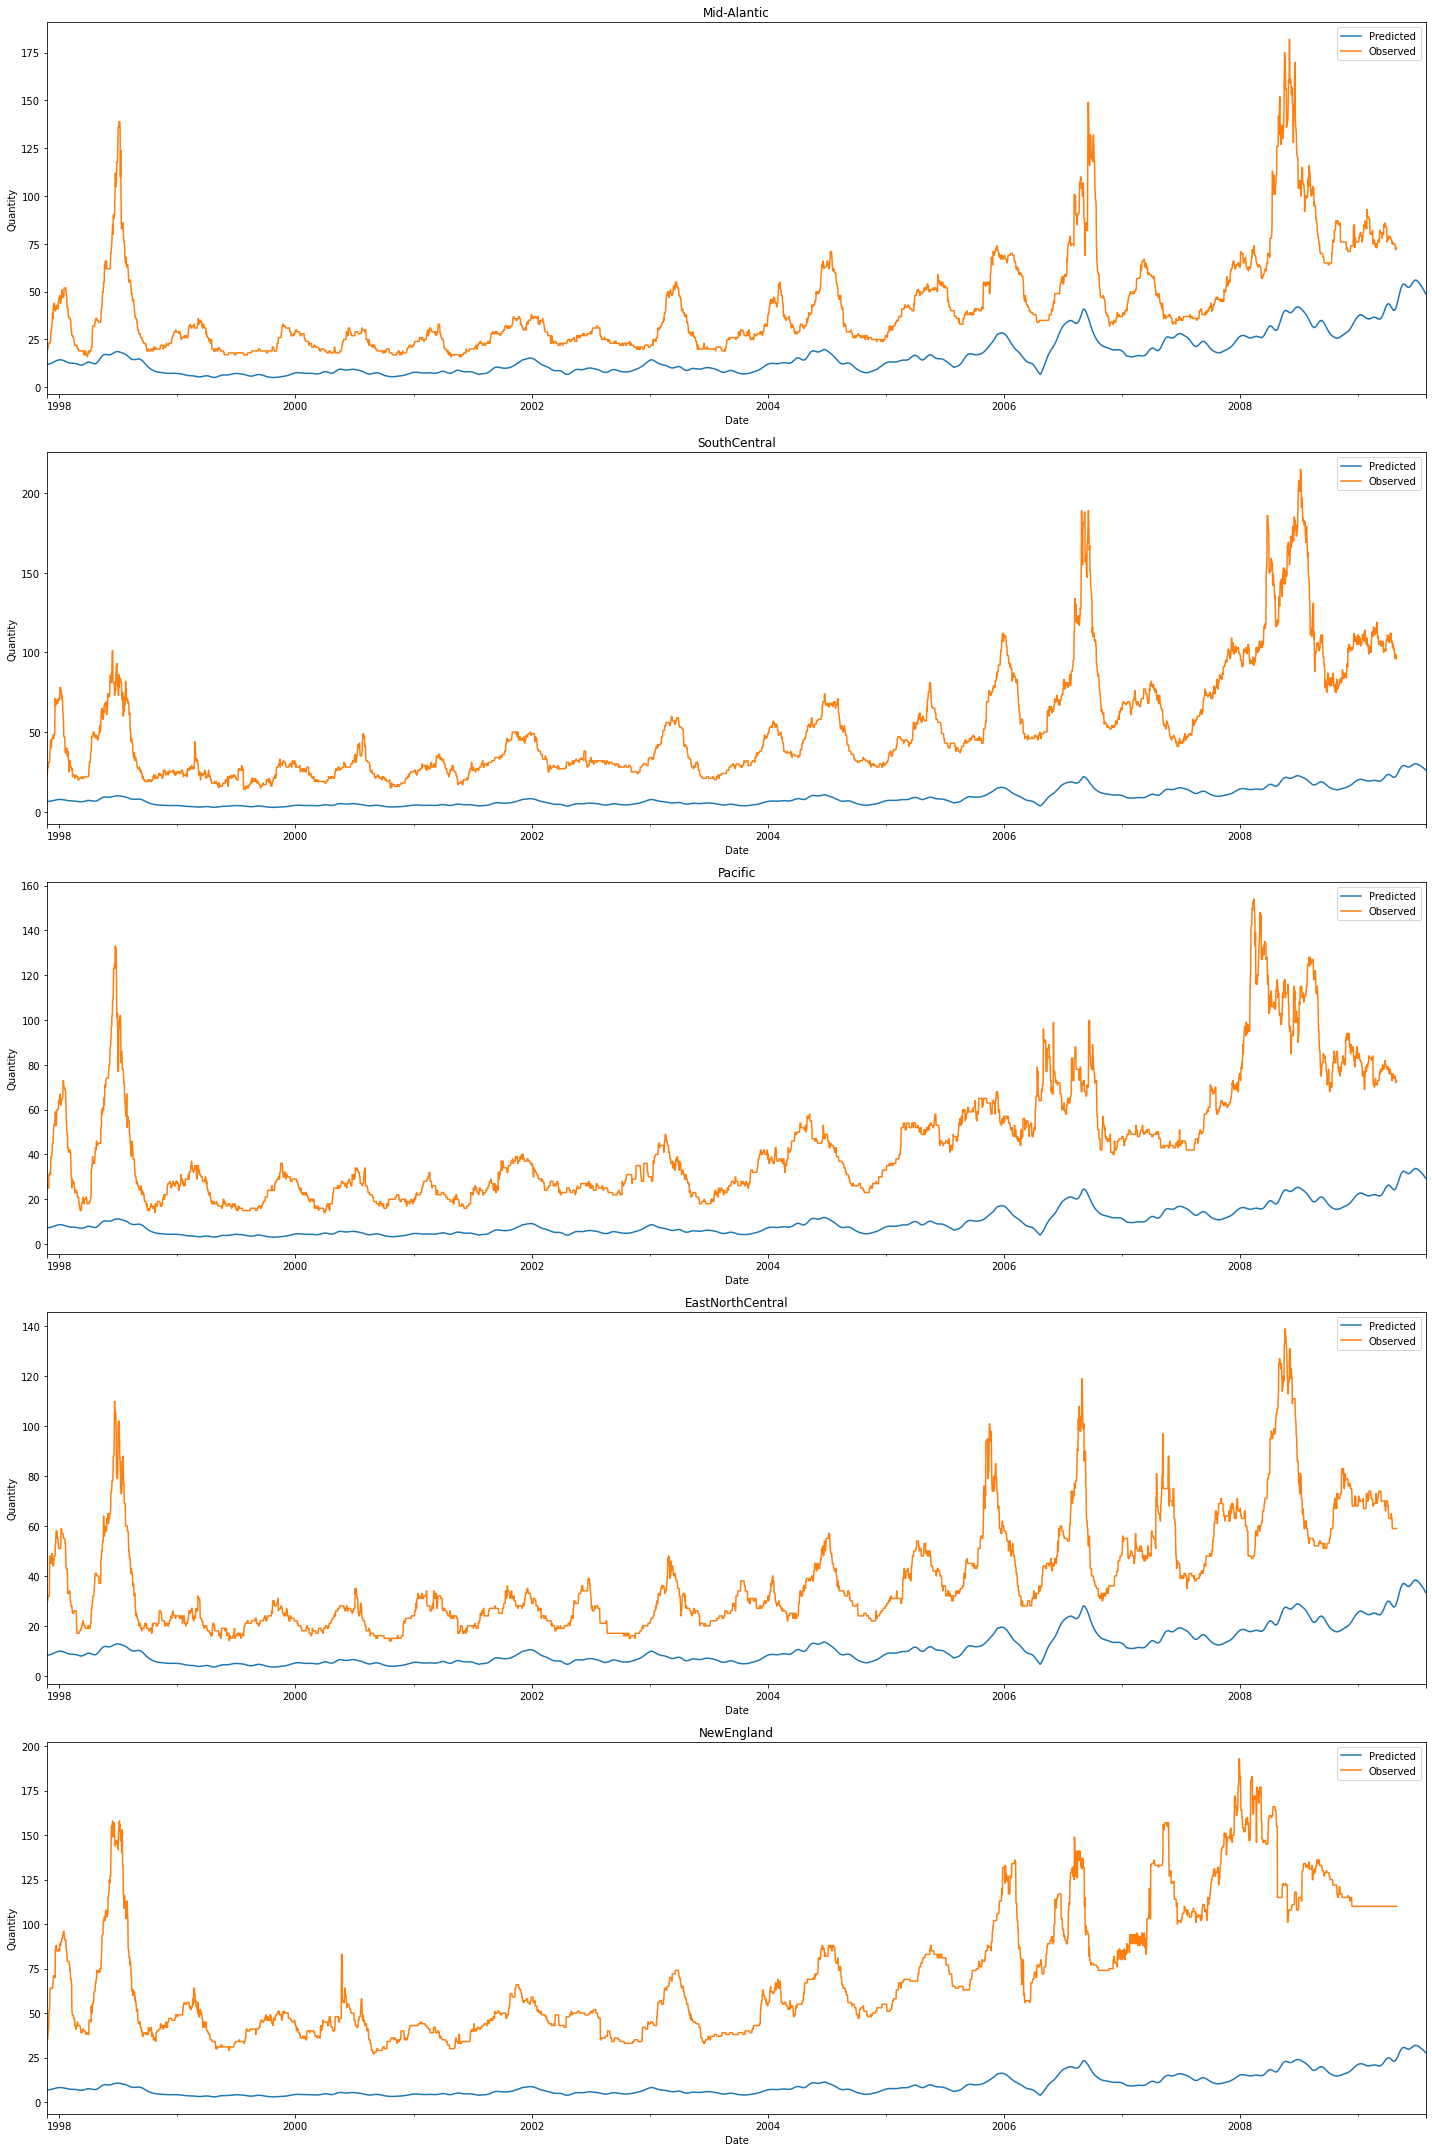

In [58]:
fig, axes = plt.subplots(len(regions), 1, figsize=(10, 20))
plot_results(regions, axes, predictions)
plt.tight_layout()

#### Visualization at State Level

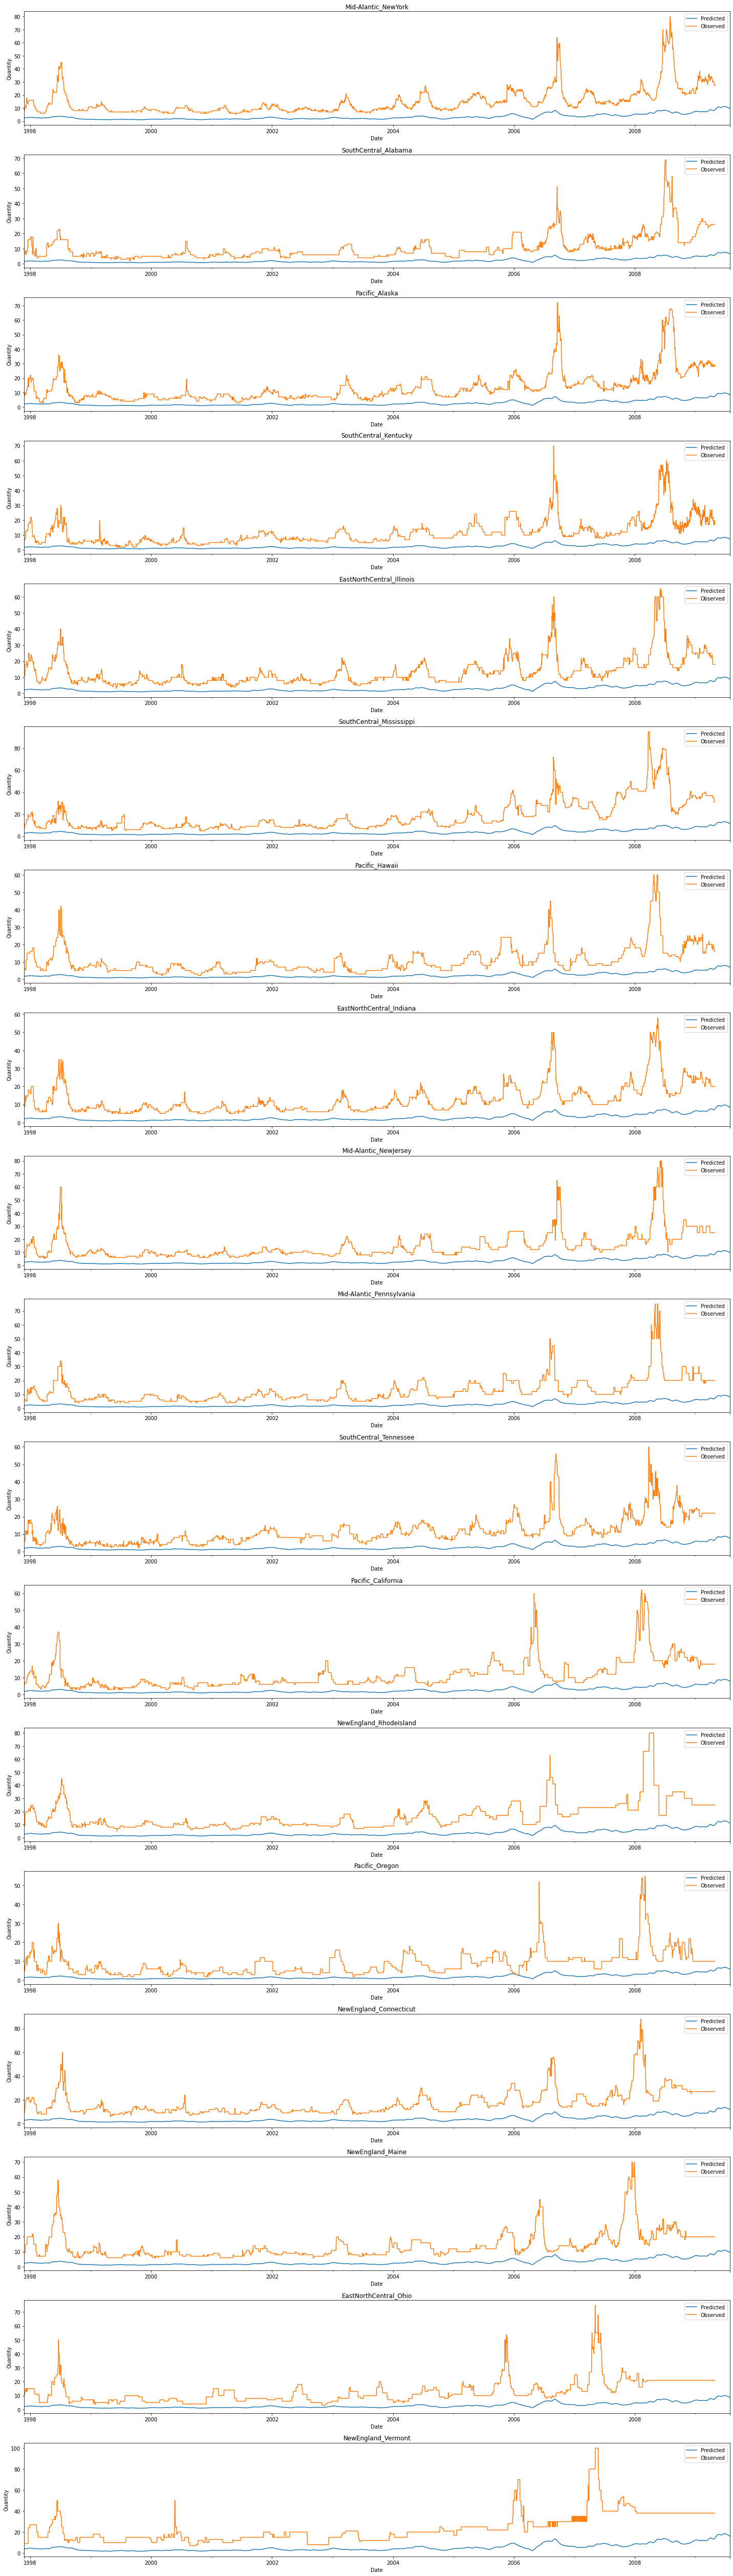

In [59]:
fig, axes = plt.subplots(len(region_states), 1, figsize=(20, 70))
plot_results(region_states, axes, predictions)
plt.tight_layout()